In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

In [2]:
# Create Spark session
spark = SparkSession.builder \
    .appName("Alzheimer's Disease Analysis") \
    .getOrCreate()

# Load the CSV file into a Spark DataFrame
file_path = "Resources/alzheimers_disease_data.csv"
alzheimers_db = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema of the DataFrame
alzheimers_db.printSchema()

# Convert to Pandas DataFrame
alzheimers_df = alzheimers_db.toPandas()

# Display basic information about the DataFrame
alzheimers_df.info()

# Display the first few rows of the DataFrame
alzheimers_df.head()


root
 |-- PatientID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Ethnicity: integer (nullable = true)
 |-- EducationLevel: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- AlcoholConsumption: double (nullable = true)
 |-- PhysicalActivity: double (nullable = true)
 |-- DietQuality: double (nullable = true)
 |-- SleepQuality: double (nullable = true)
 |-- FamilyHistoryAlzheimers: integer (nullable = true)
 |-- CardiovascularDisease: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Depression: integer (nullable = true)
 |-- HeadInjury: integer (nullable = true)
 |-- Hypertension: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- CholesterolTotal: double (nullable = true)
 |-- CholesterolLDL: double (nullable = true)
 |-- CholesterolHDL: double (nullable = true)
 |-- CholesterolTrig

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [3]:
# Data preprocessing
# Drop unnecessary columns and handle missing values
alzheimers_df = alzheimers_df.drop(columns=['PatientID', 'DoctorInCharge'])
target = alzheimers_df['Diagnosis']

# Split the data into train and test sets
X = alzheimers_df.drop(columns="Diagnosis")
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=5)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

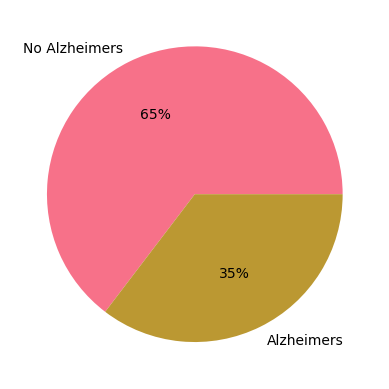

C:\Users\jacob\AppData\Local\Temp\ipykernel_10420\1703650951.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  axs[0, 0].pie(alzheimers_df.groupby('bins').size(), labels=alzheimers_df.groupby('bins').size().index, colors=colors, autopct='%.0f%%',radius=0.8)
C:\Users\jacob\AppData\Local\Temp\ipykernel_10420\1703650951.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  axs[0, 0].pie(alzheimers_df.groupby('bins').size(), labels=alzheimers_df.groupby('bins').size().index, colors=colors, autopct='%.0f%%',radius=0.8)


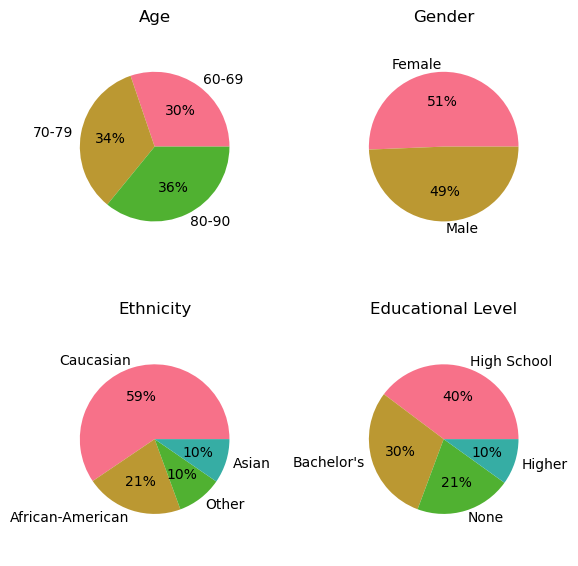

In [4]:
palette_color = sns.color_palette('husl')
plt.pie(alzheimers_df['Diagnosis'].value_counts(), labels=['No Alzheimers','Alzheimers'], colors=palette_color, autopct='%.0f%%')
plt.show()

# Define colors palette
colors = sns.color_palette('husl')

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(6,6))

# Pie chart for Age
alzheimers_df['bins'] = pd.cut(alzheimers_df['Age'], bins=[60, 69, 79, 90], labels=["60-69", "70-79", "80-90"])
axs[0, 0].pie(alzheimers_df.groupby('bins').size(), labels=alzheimers_df.groupby('bins').size().index, colors=colors, autopct='%.0f%%',radius=0.8)
axs[0, 0].set_title("Age")

# Pie chart for Gender
axs[0, 1].pie(alzheimers_df['Gender'].value_counts(), labels=['Female', 'Male'], colors=colors, autopct='%.0f%%',radius=0.8)
axs[0, 1].set_title("Gender")

# Pie chart for Ethnicity
axs[1, 0].pie(alzheimers_df['Ethnicity'].value_counts(), labels=['Caucasian', 'African-American', 'Other', 'Asian'], colors=colors, autopct='%.0f%%',radius=0.8)
axs[1, 0].set_title("Ethnicity")

# Pie chart for Educational Level
axs[1, 1].pie(alzheimers_df['EducationLevel'].value_counts(), labels=['High School', "Bachelor's", 'None', 'Higher'], colors=colors, autopct='%.0f%%',radius=0.8)
axs[1, 1].set_title("Educational Level")

# Remove the 'bins' column from the data
alzheimers_df.drop(['bins'], axis=1, inplace=True)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Initial Dataset Exploration:
- The dataset contains 2,149 observations
- There no duplicates or null values
- After removing the DoctorinCharge and PatientID columns, there are 32 alzheimers_df and 1 target(Diagnosis) variable
- 65% of patients did not have an Alzheimers diagnosis, while 35% of patients did have an Alzheimers diagnosis
- 49% of patients were Male, while the remaining 51% were Female
- A majority of patients were White (59%), 21% were Black, 10% were Asian and 10% were other
- A majority of patients were educated to the High School level (40%), 30% had Bachelors Degrees, 21% had no schooling at all and 10% had some higher education (a Masters or above)
- The age of patients was roughly similar in each of the three age groups, 36% 80-90 yr olds, 34% 70-79 yr olds, 30% 60-69 yr olds
- A limitation of the predictions of these results is that these models can't be used to predict Alzheimers in people age 59 and younger

In [5]:
#correlation matrix
corr_matrix = alzheimers_df.corr()
corr_matrix

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
Age,1.000000,0.028708,0.027745,-0.060560,-0.015677,0.020060,0.007323,-0.010249,-0.023386,0.049139,...,0.005508,0.012343,0.038973,-0.038658,0.009002,0.027523,-0.009470,0.013900,-0.019279,-0.005488
Gender,0.028708,1.000000,-0.003660,-0.007070,0.005928,0.016650,0.004330,-0.035795,0.010942,0.007310,...,0.033324,0.003880,0.006099,0.003865,-0.030583,0.017506,0.025919,-0.001636,-0.028537,-0.020975
Ethnicity,0.027745,-0.003660,1.000000,0.026516,-0.003176,0.031485,0.008363,0.020498,-0.018184,0.029304,...,-0.004704,0.003687,-0.019363,0.010475,0.022431,-0.018132,-0.030035,0.019363,-0.034619,-0.014782
EducationLevel,-0.060560,-0.007070,0.026516,1.000000,-0.023514,-0.009904,-0.012646,-0.016703,0.017412,0.020248,...,0.020269,-0.000165,0.010473,0.031934,-0.008168,-0.017568,-0.019950,0.013033,-0.008685,-0.043966
BMI,-0.015677,0.005928,-0.003176,-0.023514,1.000000,0.020437,-0.008997,0.000742,0.019922,-0.005975,...,-0.030501,0.029293,0.035276,-0.009788,-0.015859,-0.031840,-0.015901,-0.039400,0.071131,0.026343
Smoking,0.020060,0.016650,0.031485,-0.009904,0.020437,1.000000,0.008363,0.010760,-0.002048,-0.001145,...,-0.031879,0.020339,-0.014763,-0.029233,0.004498,-0.028403,-0.009977,0.001741,0.018011,-0.004865
AlcoholConsumption,0.007323,0.004330,0.008363,-0.012646,-0.008997,0.008363,1.000000,0.021696,0.020117,-0.003873,...,-0.016483,-0.029418,0.013657,-0.008250,-0.032798,0.015521,0.019117,-0.002712,-0.024121,-0.007618
PhysicalActivity,-0.010249,-0.035795,0.020498,-0.016703,0.000742,0.010760,0.021696,1.000000,0.011085,-0.001823,...,-0.002419,0.008709,-0.014253,-0.013324,-0.009397,-0.020407,-0.013629,0.031169,0.009837,0.005945
DietQuality,-0.023386,0.010942,-0.018184,0.017412,0.019922,-0.002048,0.020117,0.011085,1.000000,0.051295,...,-0.009700,0.012537,-0.014033,-0.007888,0.002628,-0.026271,0.029087,0.045737,0.006175,0.008506
SleepQuality,0.049139,0.007310,0.029304,0.020248,-0.005975,-0.001145,-0.003873,-0.001823,0.051295,1.000000,...,0.029589,-0.016807,-0.019899,0.014535,0.013508,0.019467,-0.016892,0.011237,0.002930,-0.056548


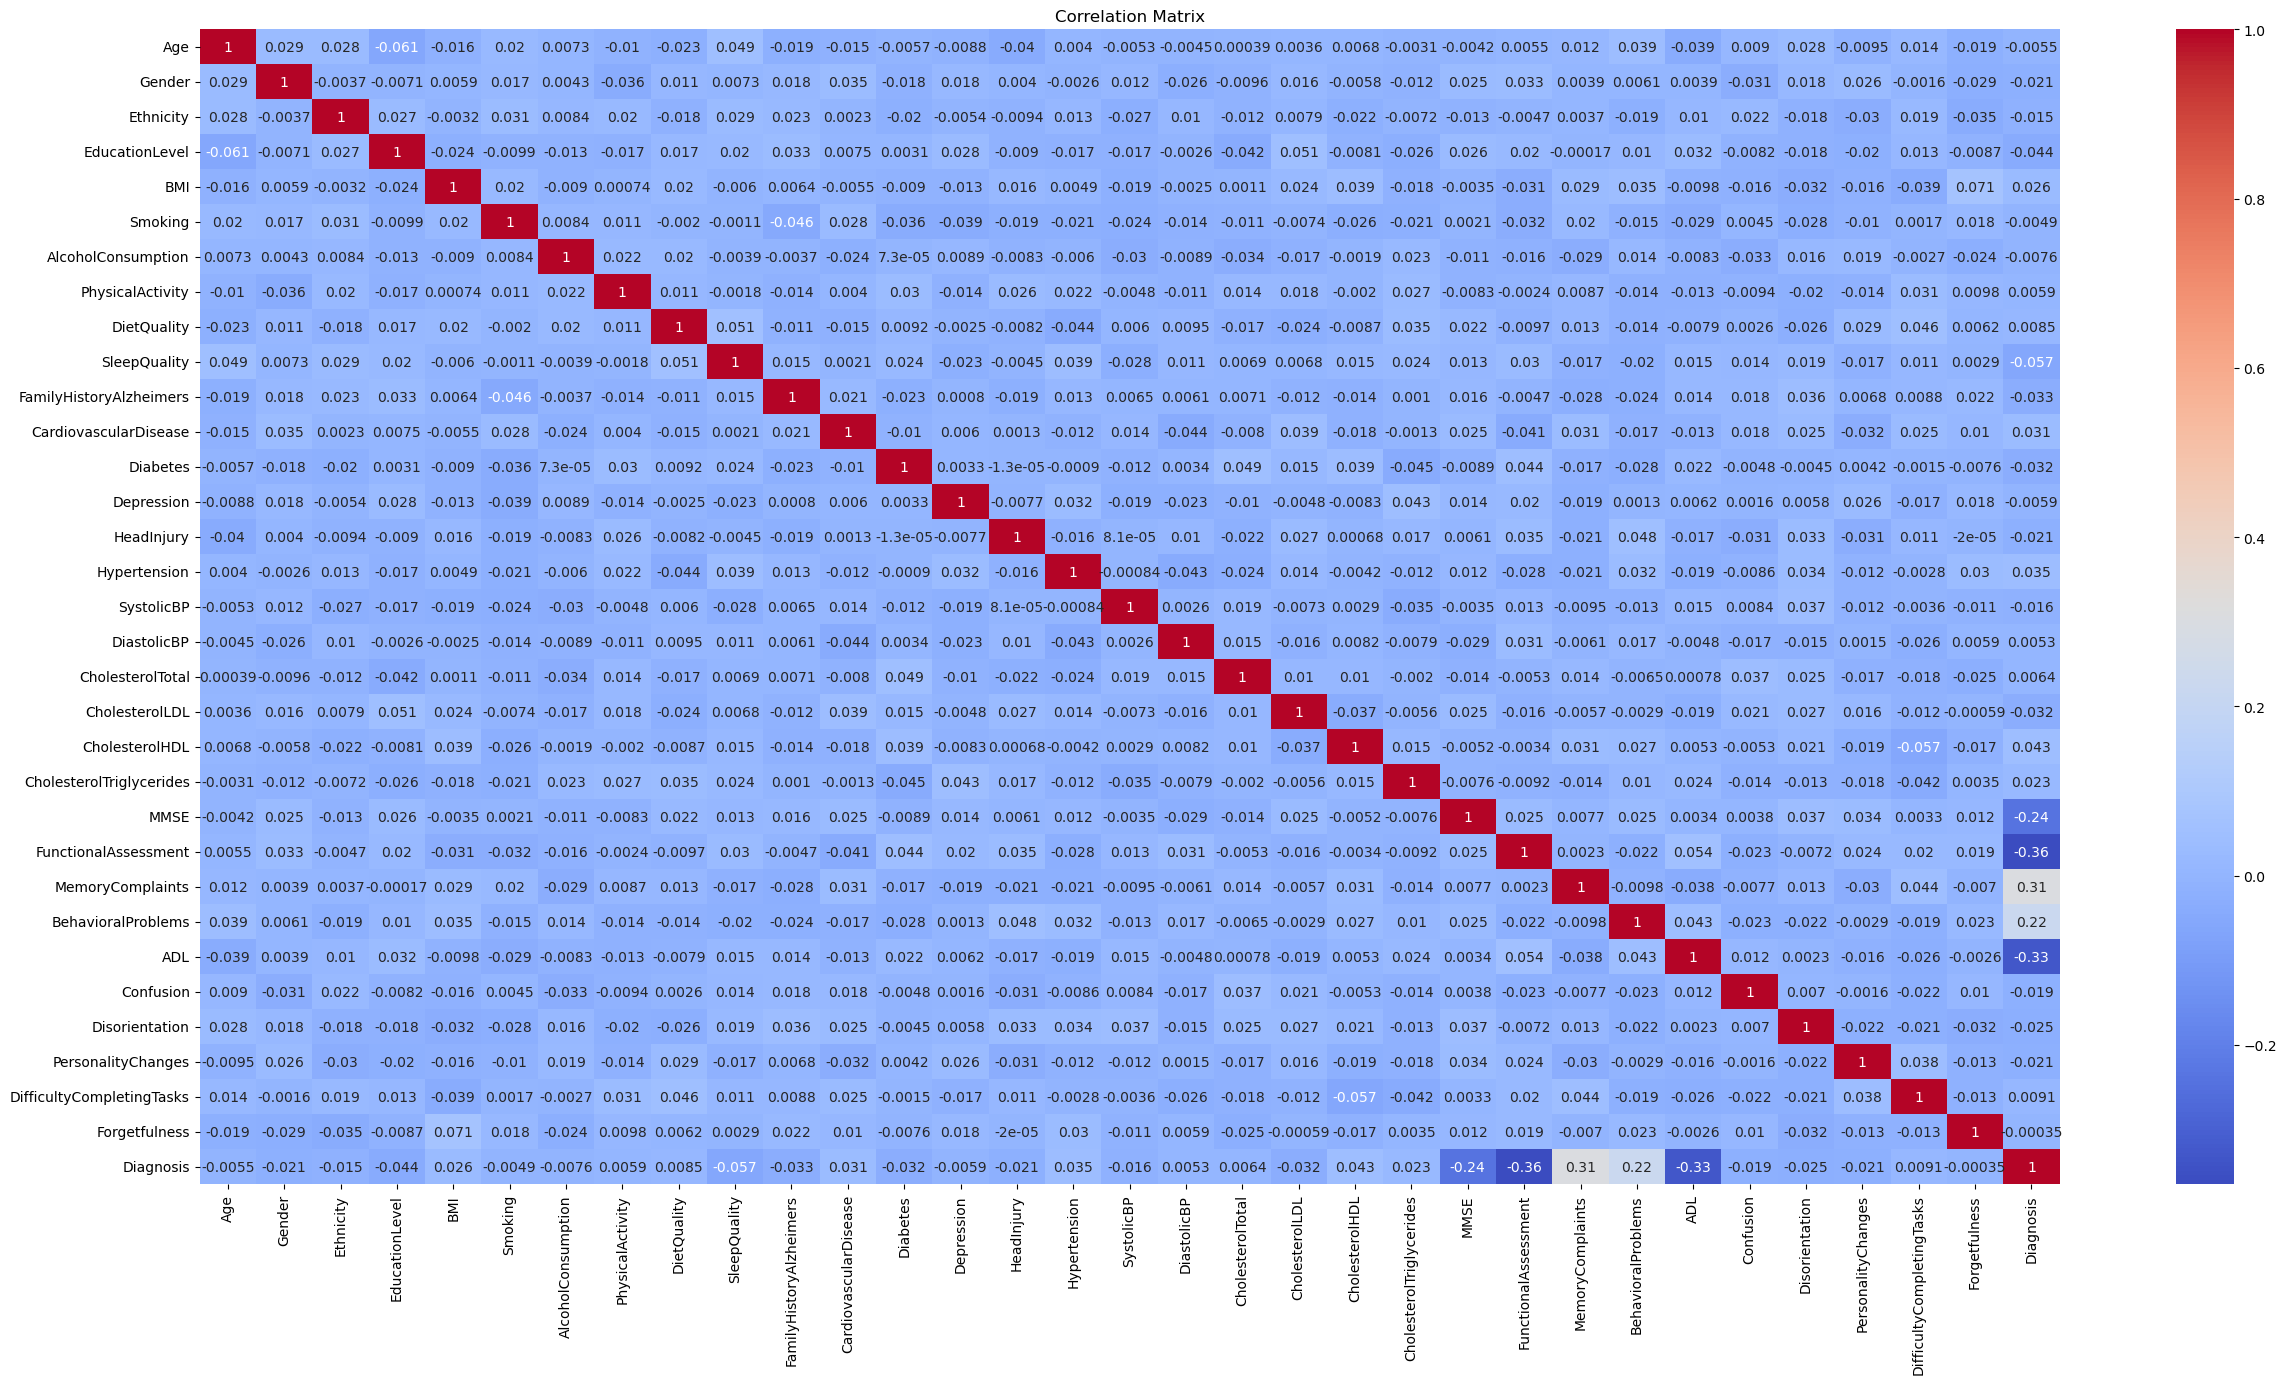

In [6]:
#show and save a heatmap of the correlation matrix
plt.figure(figsize = (30,15))
svm = sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, square=False)
plt.title('Correlation Matrix')
plt.show()
figure = svm.get_figure()
figure.savefig('Images/corr_matrix.png', dpi=400)

## Looking at most correlated features with Diagnosis

In [7]:
#get an array of the features that are correlated with Diagnosis and their correlations
corr_diagnosis = corr_matrix["Diagnosis"].reset_index()

#rename the columns of the array to Feature and Correlation
corr_diagnosis.columns = ['Feature', 'Correlation']

#filter the array to only 'Correlations' that are > 0.03 and < -0.03
filtered_corr_diagnosis = corr_diagnosis[(corr_diagnosis['Correlation'] > 0.03) | (corr_diagnosis['Correlation'] < -0.03)]

#filter the array to make sure 'Diagnosis' is not one of the features (of course it's correlated with itself)
filtered_corr_diagnosis = filtered_corr_diagnosis [filtered_corr_diagnosis['Feature'] != 'Diagnosis']

#sort the array in descending order to include the highest positive correlations first
sorted_corr_diagnosis = filtered_corr_diagnosis.sort_values(by= 'Correlation', ascending=False)
sorted_corr_diagnosis

,Feature,Correlation
24,MemoryComplaints,0.306742
25,BehavioralProblems,0.224350
20,CholesterolHDL,0.042584
15,Hypertension,0.035080
11,CardiovascularDisease,0.031490
12,Diabetes,-0.031508
19,CholesterolLDL,-0.031976
10,FamilyHistoryAlzheimers,-0.032900
3,EducationLevel,-0.043966
9,SleepQuality,-0.056548


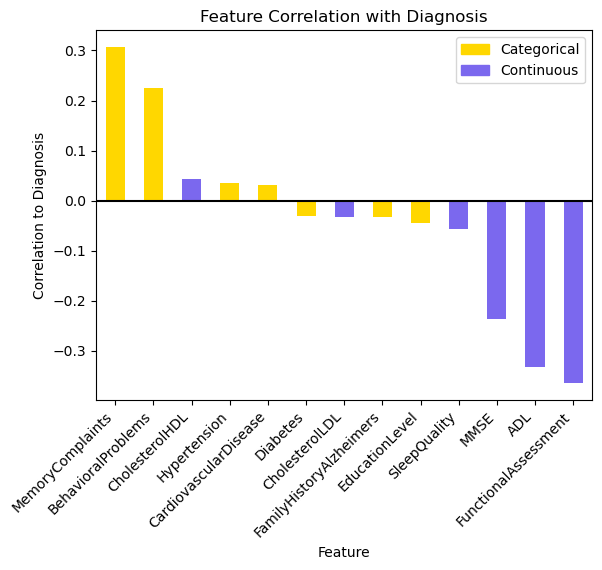

In [8]:
#create a list of categorical columns
categorical = ["MemoryComplaints","BehavioralProblems","Hypertension","CardiovascularDisease","Diabetes","FamilyHistoryAlzheimers","EducationLevel"]
#create a list of continuous columns
continuous = ["CholesterolHDL","CholesterolLDL","SleepQuality","MMSE","ADL","FunctionalAssessment"]
#create a variable that holds the color of the bar, depending on whether the column is categorical or continous
colors = ['gold' if feature in categorical else 'mediumslateblue' for feature in sorted_corr_diagnosis['Feature']]

#create the bar plot with matplotlib looking at Correlation with Feature as the index and colors determining the color of the bar
ax = sorted_corr_diagnosis.set_index('Feature')['Correlation'].plot(kind='bar', color=colors)
#draw the center line at 0 black
plt.axhline(0, color='k')
#create a variable that holds the legend info using Patch
legend_handles = [
    Patch(color='gold', label='Categorical'),
    Patch(color='mediumslateblue', label='Continuous')
]
#create a legend, using legend_handles to determine legend details and setting the location of the legend to best
ax.legend(handles=legend_handles, loc='best')
#setting ylabel, xticks and title and showing the plot
plt.ylabel('Correlation to Diagnosis')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Correlation with Diagnosis')
plt.show()

## Initial Correlation Interpretation
- It is important to note that pearson correlations between categorical variables are not valid
- Here we use 0.03 and -0.03 as a cutoff to indicate the "most correlated variables", however typically the closer the correlation is to 1, the better the correlation so correlation below 0.5 are considered weakly correlated.
- The continuous variables that were most correlated with Diagnosis were Functional Assessment, ADL (Activities of Daily Living), and MMSE
- The relationships are negative, indicating
    - As Functional Assessment score decreases, likelihood of being diagnosed with Alzheimers increases
    - As Activities of Daily Living (ADL) score decreases, likelihood of being diagnosed with Alzheimers increases
    - As MMSE(Mini Mental State Exam) score decreases, likelihood of being diagnosed with Alzheimers increases

## Box plots for continuous variables

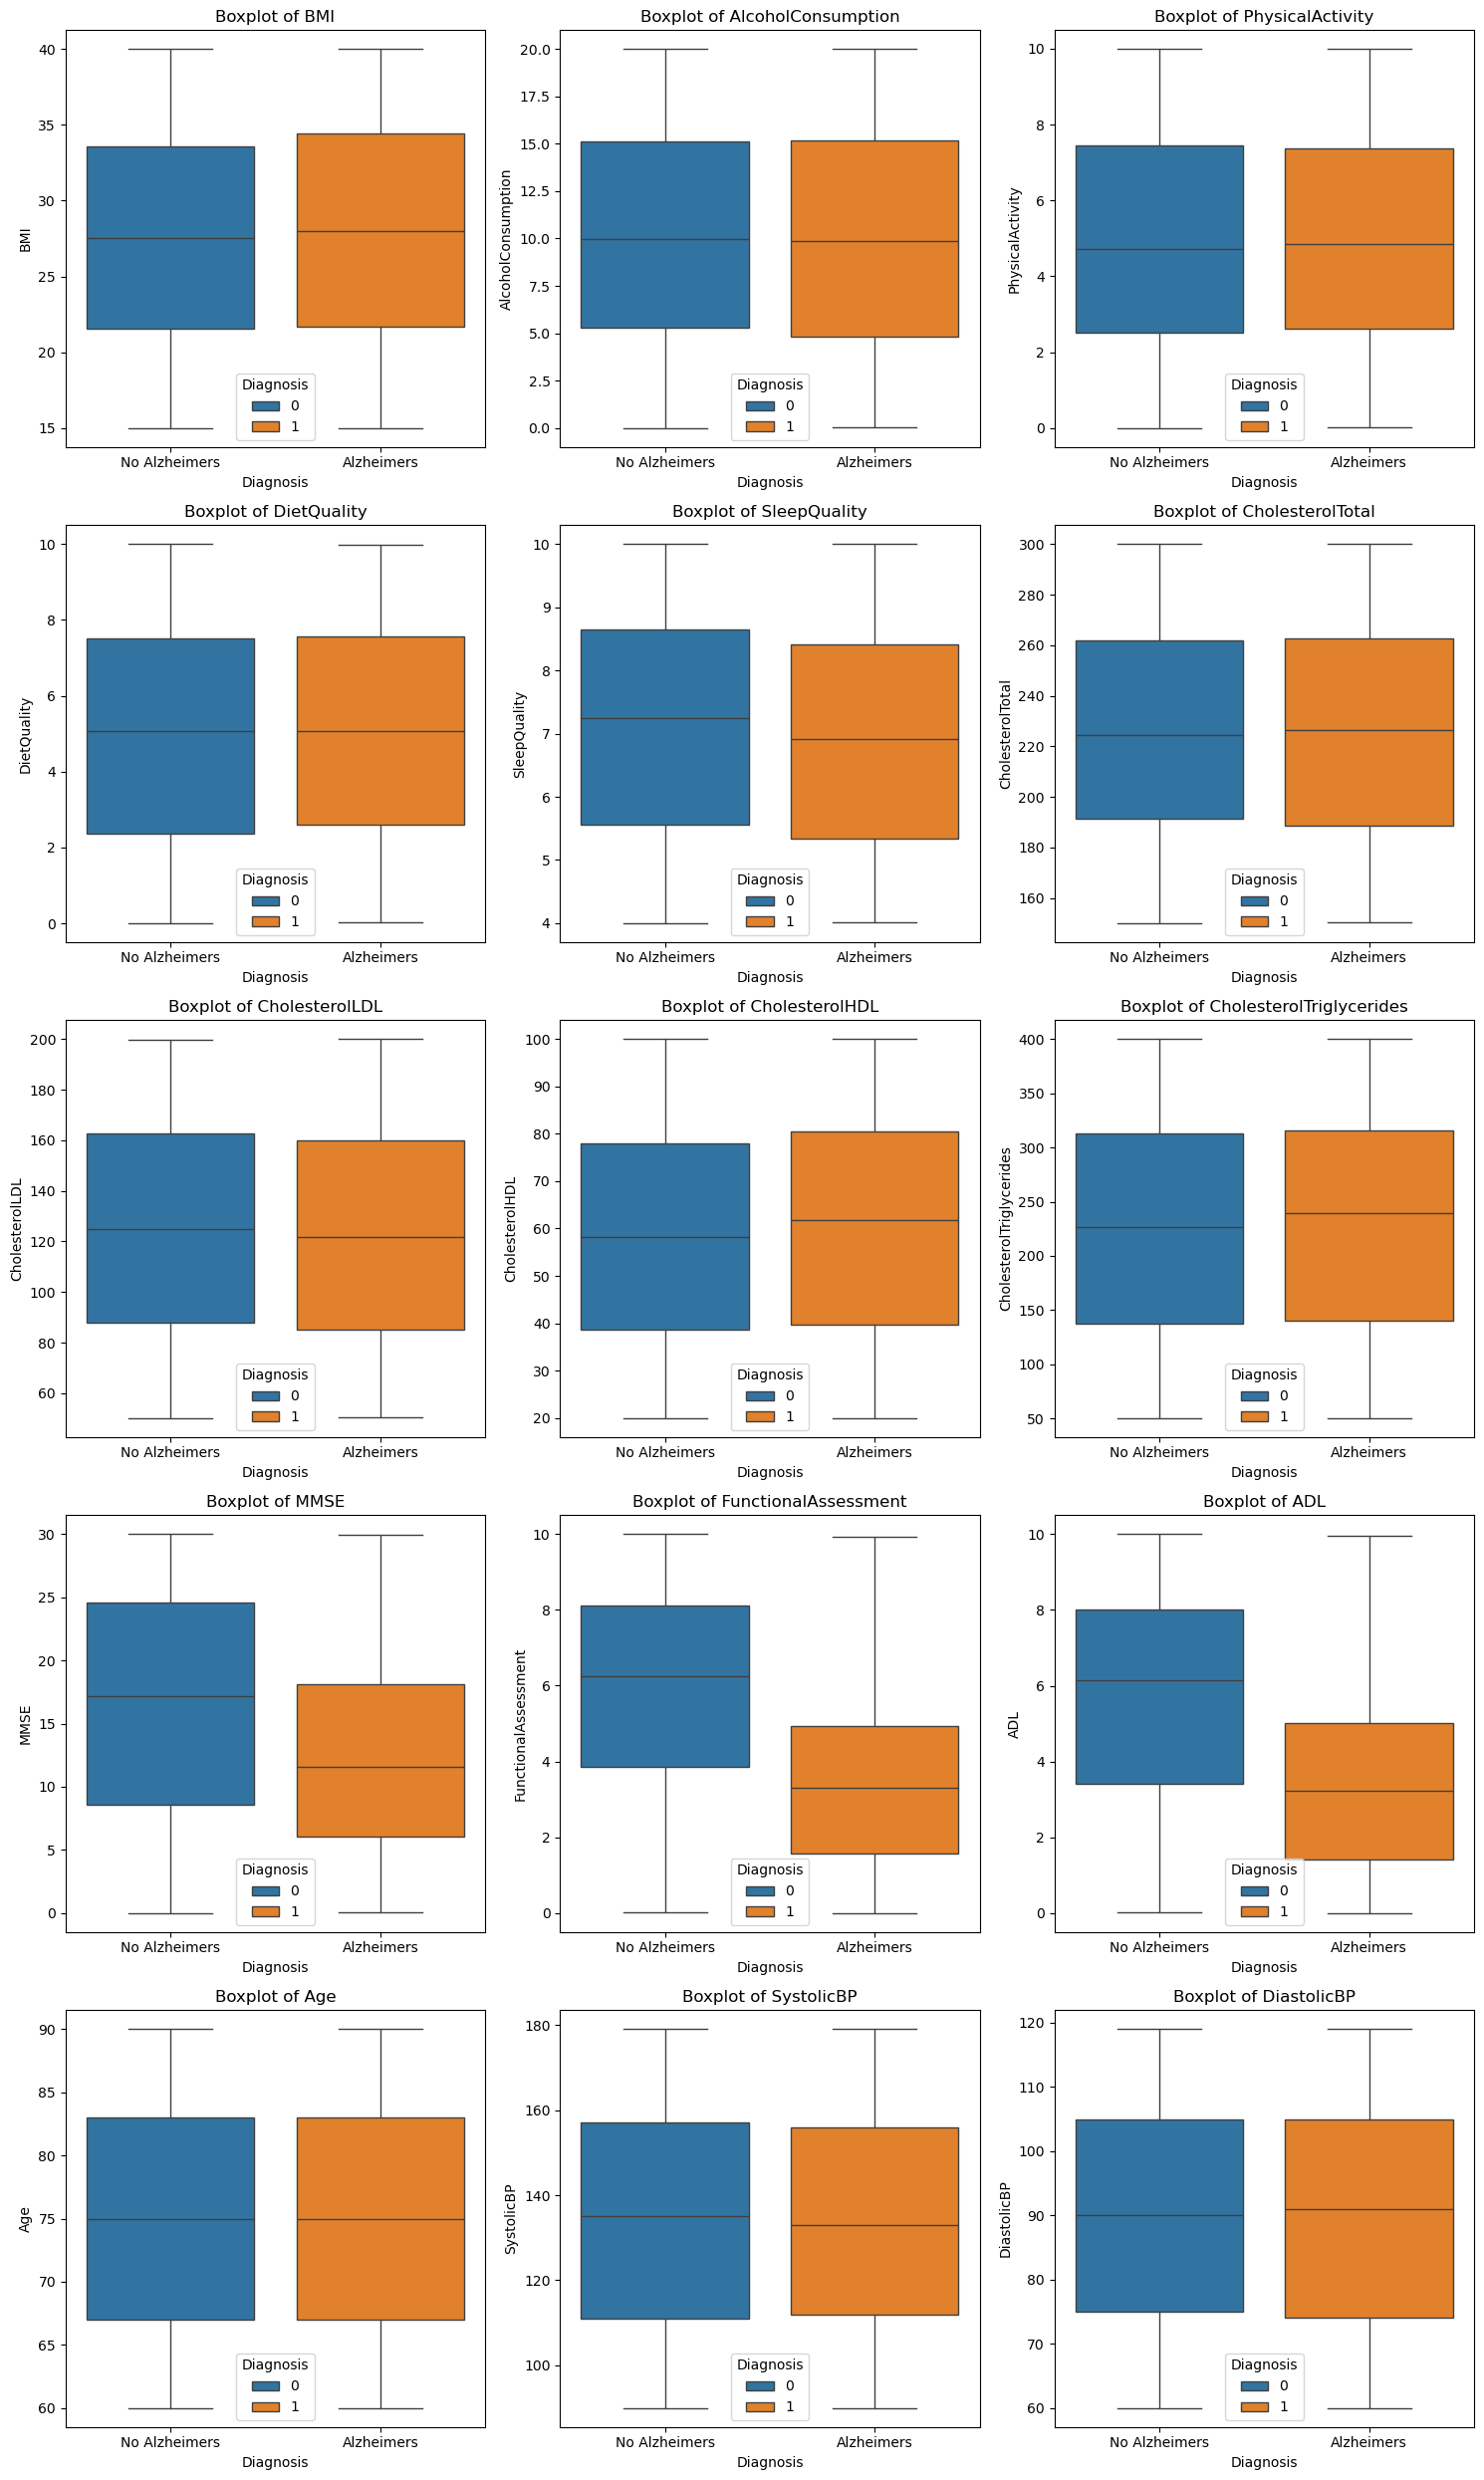

In [9]:
#define the columns to be plotted (all float variables and 3 integer variables: Age, SystolicBP and DiastolicBP)
cols2scale = (alzheimers_df.columns[alzheimers_df.dtypes == 'float64']).tolist() + ['Age', 'SystolicBP', 'DiastolicBP']
#number of columns
num_cols = len(cols2scale)
#calculate the number of rows needed for the grid (3 columns per row)

#create the subplots
fig, axes = plt.subplots(5, 3, figsize=(15, 5 * 5))

#Flatten the axes array for easy iteration
axes = axes.flatten()

for i, col in enumerate(cols2scale):
    sns.boxplot(data = alzheimers_df, y=col, x='Diagnosis', ax=axes[i], hue = 'Diagnosis')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('Diagnosis')
    axes[i].set_ylabel(col)
    axes[i].set_xticks(ticks=[0,1], labels=['No Alzheimers','Alzheimers'])
    axes[i].legend(title = 'Diagnosis', loc = 'lower center')
#hide any unused subplots
for j in range(num_cols, len(axes)):
    axes[j].axis('off')

#adjust layout to prevent overlap
plt.tight_layout()
#show the plot
plt.show()

## Boxplot Interpretations:
- As is expected from the correlations, we see that there is a difference between the average MMSE, ADL and Functional Assessment scores for non-diagnosed people as compared to diagnosed people (scores were lower for people with Alzheimers)
    - It is important to note that Functional Assessment, ADL and MMSE are the top 3 most important features according to a feature_importances analysis further down in the notebook
- The rest of the averages appear to be somewhat similar except Sleep Quality, Cholesterol HDL and Cholesterol Triglycerides
- Sleep Quality appears to be lower for people with Alzheimers
- Cholesterol HDL and Triglycerides appear to be higher in people with Alzheimers
    - It is important to note that Sleep Quality and Cholesterol Triglycerides appear later in Feature Importances as being apart of the top 10 important features (9th and 8th)
- Physical Activity, Diet Quality, and BMI average do not appear much different for persons with alzheimers vs persons without alzheimers
However these three variables were 6th, 7th and 10th in the most important features according to a Random Forest feature_importances analysis

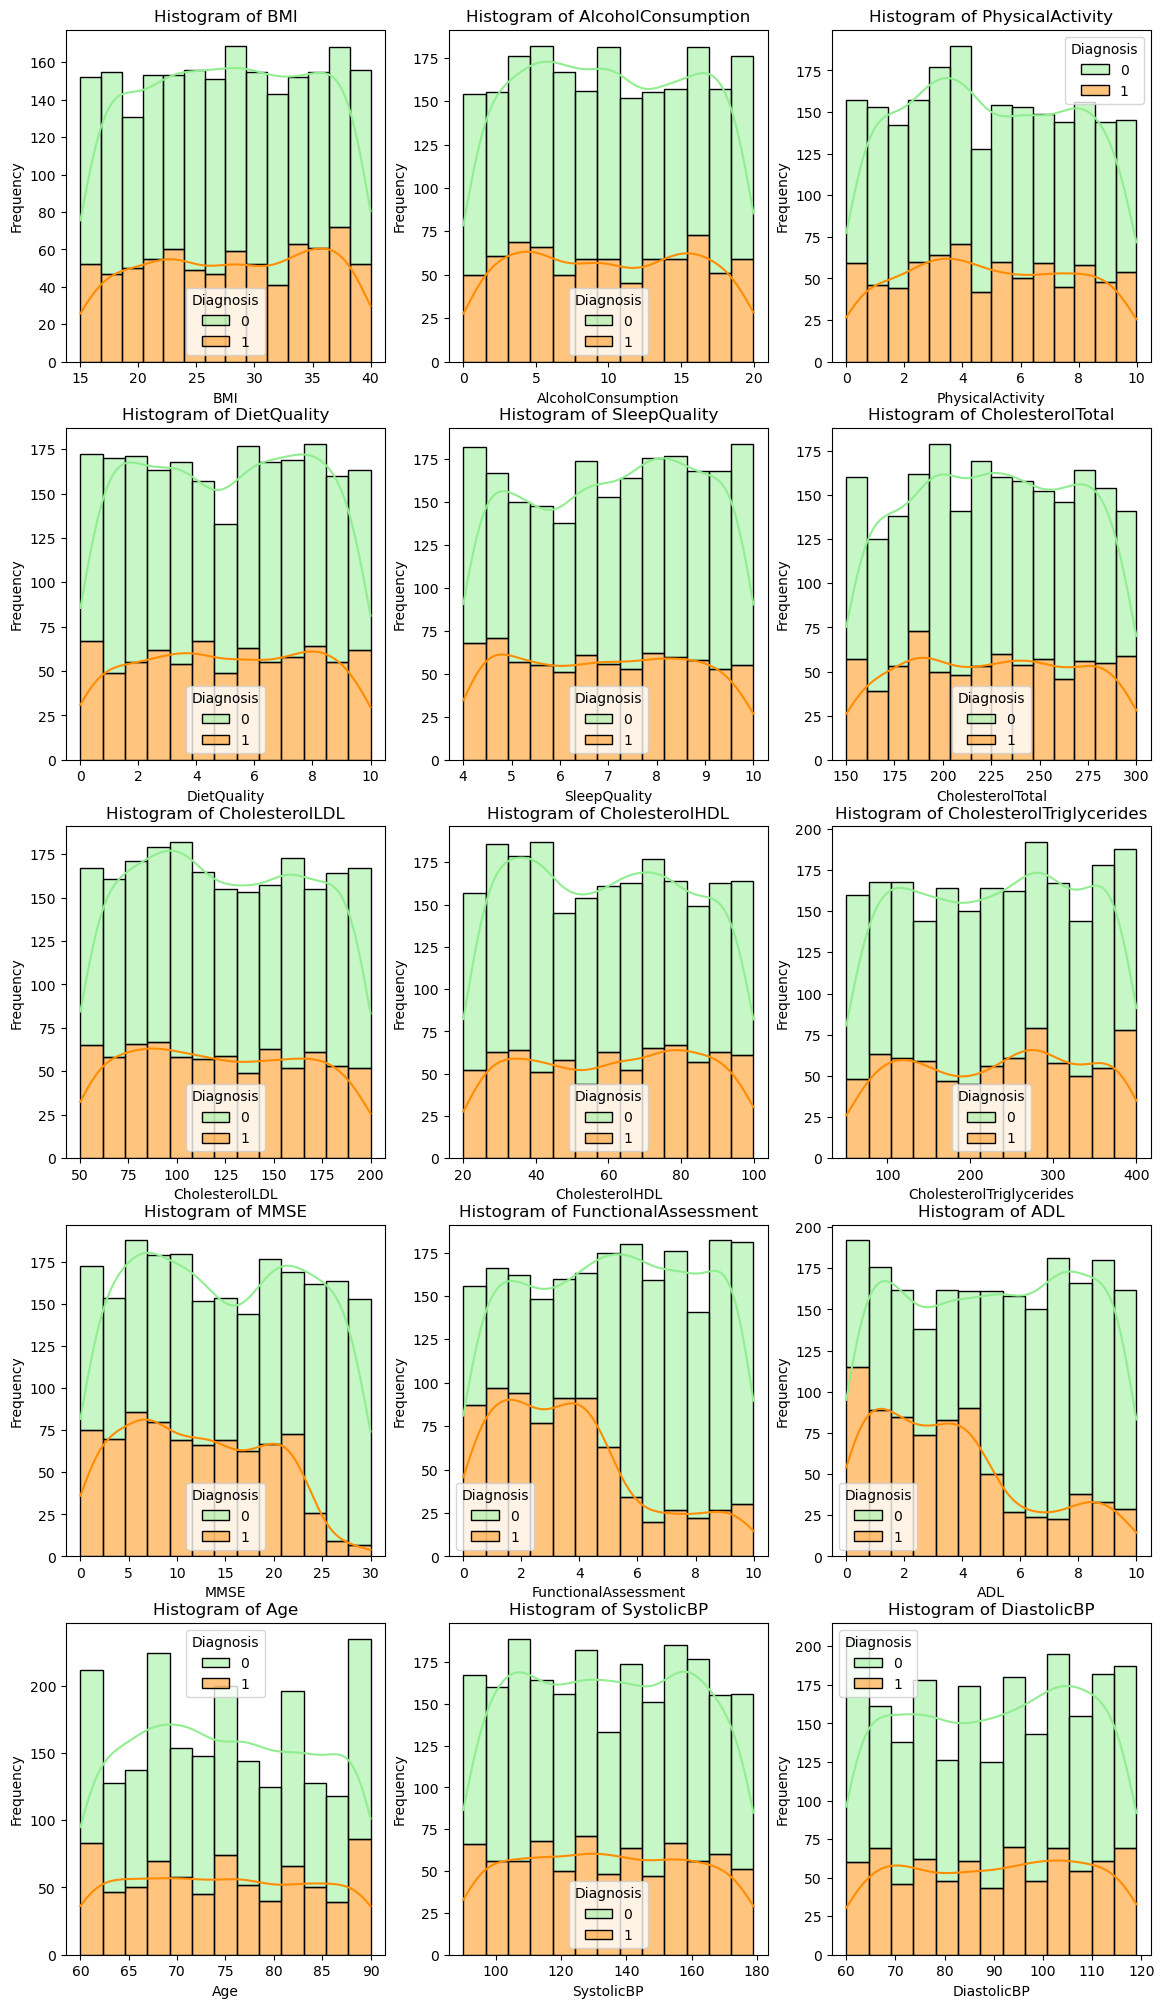

In [10]:
# columns_to_plot = alzheimers_df[['ADL', 'MMSE', 'FunctionalAssessment', 'Age']]

columns_to_plot = (alzheimers_df.columns[alzheimers_df.dtypes=='float64']).tolist()+['Age', 'SystolicBP', 'DiastolicBP']

alzheimers_df[columns_to_plot].head()

num_cols = len(columns_to_plot)
num_rows = (num_cols + 1) // 3

fig, axs =plt.subplots(num_rows, 3, figsize=(14, num_rows * 5))

axs = axs.flatten()
colors = sns.color_palette('Set2')

for i, col in enumerate(columns_to_plot):
    sns.histplot(data = alzheimers_df, x=col, hue='Diagnosis', kde=True, multiple='stack', ax=axs[i], palette=['lightgreen', 'darkorange'])
    axs[i].set_title(f'Histogram of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')

## Chi Square tests for categorical variables

In [11]:
#separating categorical and continuous variables
categorical_variables = alzheimers_df[["Gender","EducationLevel","Ethnicity","Smoking","FamilyHistoryAlzheimers", "CardiovascularDisease","Diabetes","Depression","HeadInjury","Hypertension","MemoryComplaints", "BehavioralProblems", "Confusion", "Disorientation", "PersonalityChanges", "DifficultyCompletingTasks","Forgetfulness", "Diagnosis"]]
continuous_variables = alzheimers_df[["Age","BMI","AlcoholConsumption","PhysicalActivity","DietQuality","SleepQuality","SystolicBP", "DiastolicBP","CholesterolTotal","CholesterolLDL","CholesterolHDL", "CholesterolTriglycerides","MMSE","FunctionalAssessment","ADL"]]
diagnosis = alzheimers_df["Diagnosis"]

#defining a function to perform a chi square test and return results (chi2, p-value, degrees of freedom, expected, and contingency_table) in a matrix
def chi_square_test(dataframe, target_var, other_var):
    #create contingency table
    contingency_table = pd.crosstab(dataframe[target_var], dataframe[other_var])
    #perform Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    return chi2, p, dof, expected, contingency_table

#specify the target variable
target_variable = 'Diagnosis'

#list all other variables except Diagnosis
other_variables = categorical_variables.columns.difference(['Diagnosis'])

#Initialize results into a list
results = []

#Perform chi-square test for each variable against the target variable
for other_var in other_variables:

        chi2, p, dof, expected, table = chi_square_test(categorical_variables, target_variable, other_var)

        results.append({
            'Other Variable': other_var,
            'Chi2 Statistic': chi2,
            'P-Value': p,
            'Degrees of Freedom': dof,
            'Contingency Table': table,
            'Expected Frequencies': expected
        })
#convert results to dataframe
results_df = pd.DataFrame(results)
results_df['P-Value'] = results_df['P-Value'].apply(lambda x: format(x, '.6f'))
results_df


,Other Variable,Chi2 Statistic,P-Value,Degrees of Freedom,Contingency Table,Expected Frequencies
0,BehavioralProblems,106.879217,0.000000,1,BehavioralProblems 0 1 Diagnosis ...,"[[1171.181014425314, 217.8189855746859], [640...."
1,CardiovascularDisease,1.947683,0.162837,1,CardiovascularDisease 0 1 Diagnosis ...,"[[1188.6323871568172, 200.36761284318288], [65..."
2,Confusion,0.694786,0.404541,1,Confusion 0 1 Diagnosis 0 ...,"[[1103.9609120521172, 285.03908794788276], [60..."
3,Depression,0.047019,0.828334,1,Depression 0 1 Diagnosis 0 ...,"[[1110.4243834341555, 278.5756165658446], [607..."
4,Diabetes,1.953177,0.162245,1,Diabetes 0 1 Diagnosis 0 ...,"[[1179.5835272219638, 209.4164727780363], [645..."
5,DifficultyCompletingTasks,0.128631,0.719856,1,DifficultyCompletingTasks 0 1 Diagnosis...,"[[1168.5956258724989, 220.40437412750117], [63..."
6,Disorientation,1.168140,0.279784,1,Disorientation 0 1 Diagnosis ...,"[[1169.2419730107026, 219.75802698929735], [63..."
7,EducationLevel,4.453147,0.216508,3,EducationLevel 0 1 2 3 Diagnosis ...,"[[288.2708236389018, 551.9804560260586, 411.07..."
8,Ethnicity,6.302089,0.097803,3,Ethnicity 0 1 2 3 Diagnosis ...,"[[826.0316426244765, 293.44160074453237, 133.1..."
9,FamilyHistoryAlzheimers,2.170309,0.140698,1,FamilyHistoryAlzheimers 0 1 Diagnosis ...,"[[1038.6798510935319, 350.32014890646815], [56..."


In [12]:
#save results to csv to view p value in non-scientific figures
results_df.to_csv('Images/Chi2.csv')

## Chi Squared Interpretations:
- In a chi squared test a p-value of < 0.05 is significant
- As was expected from the correlation matrix, we see that Behavioral Problems and Memory Complaints Chi Squared tests are significant
    - Behavioral Problems: Chi2 = 106.88, p-value = 0.000000
    - Memory Complaints: Chi2 = 200.62, p-value = 0.000000

## Barplots for categorical variables of interest

### MemoryComplaints

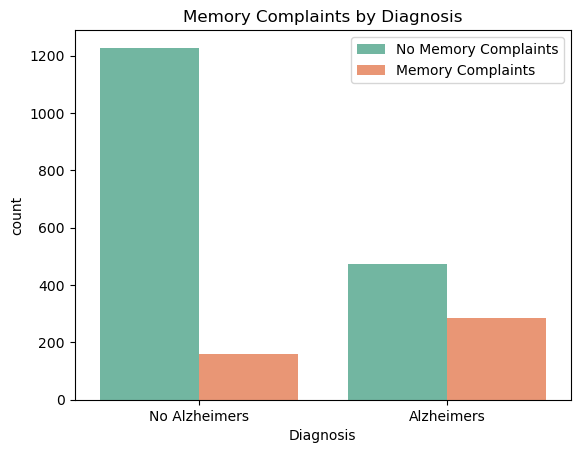

In [13]:
sns.countplot(data=alzheimers_df, x='Diagnosis', hue='MemoryComplaints', palette = 'Set2')
plt.legend(labels=['No Memory Complaints','Memory Complaints'])
plt.xticks(ticks=[0,1], labels=['No Alzheimers','Alzheimers'])
plt.title(f'Memory Complaints by Diagnosis')
plt.show()

### BehavioralProblems

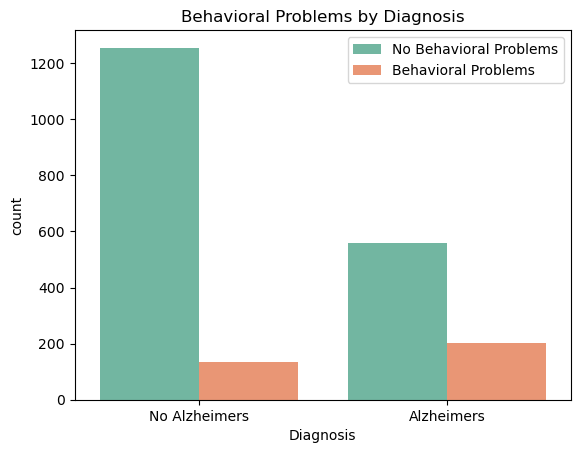

In [14]:

sns.countplot(data=alzheimers_df, x='Diagnosis', hue='BehavioralProblems', palette = 'Set2')
plt.legend(labels=['No Behavioral Problems','Behavioral Problems'])
plt.xticks(ticks=[0,1], labels=['No Alzheimers','Alzheimers'])
plt.title(f'Behavioral Problems by Diagnosis')
plt.show()

### Gender
- Gender was not significant according to a Chi Squared test (p-value = 0.35)

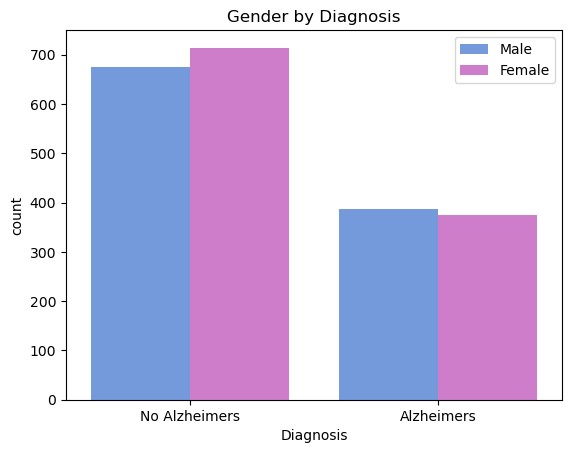

In [15]:
sns.countplot(data=alzheimers_df, x='Diagnosis', hue='Gender', palette = ['cornflowerblue','orchid'])
plt.legend(labels=['Male','Female'])
plt.xticks(ticks=[0,1], labels=['No Alzheimers','Alzheimers'])
plt.title(f'Gender by Diagnosis')
plt.show()

### EducationLevel
- Education level was not significant in a Chi Square test (p-value = 0.22)

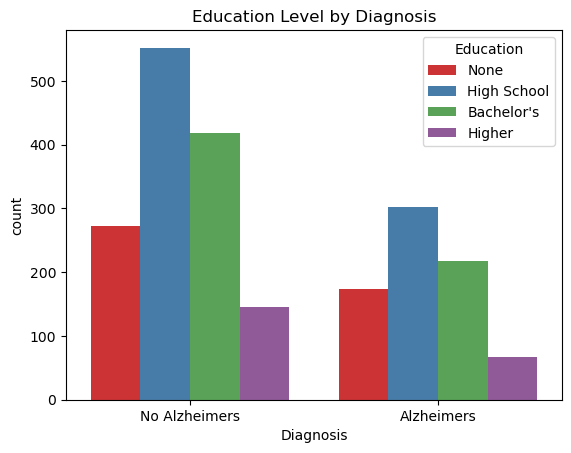

In [16]:
sns.countplot(data=alzheimers_df, x='Diagnosis', hue='EducationLevel', palette = 'Set1')
plt.legend(title = "Education", labels=['None','High School',"Bachelor's",'Higher'])
plt.xticks(ticks=[0,1], labels=['No Alzheimers','Alzheimers'])
plt.title(f'Education Level by Diagnosis')
plt.show()

### Ethnicity
- Ethnicity was not significant according to a Chi squared test (p-value = 0.09) but was much closer to significance

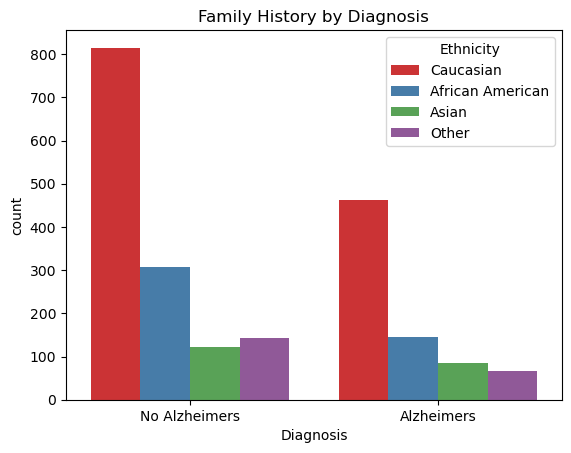

In [17]:
sns.countplot(data=alzheimers_df, x='Diagnosis', hue='Ethnicity', palette = 'Set1')
plt.legend(title = 'Ethnicity', labels=['Caucasian','African American','Asian','Other'])
plt.xticks(ticks=[0,1], labels=['No Alzheimers','Alzheimers'])
plt.title(f'Family History by Diagnosis')
plt.show()

### FamilyHistoryAlzheimers
- Family History of Diagnosis was not significant according to a Chi Squared test (p-value = 0.14)

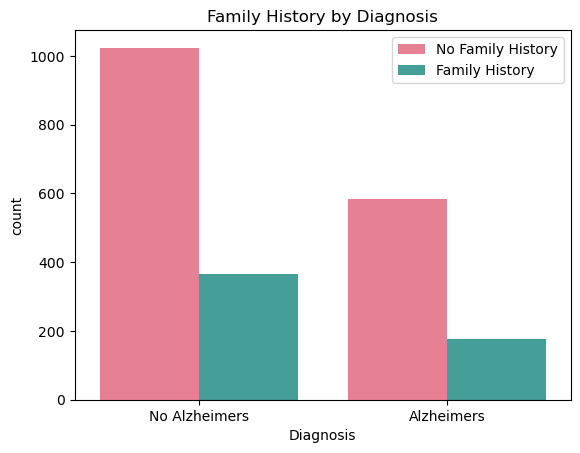

In [18]:
sns.countplot(data=alzheimers_df, x='Diagnosis', hue='FamilyHistoryAlzheimers', palette = 'husl')
plt.legend(labels=['No Family History','Family History'])
plt.xticks(ticks=[0,1], labels=['No Alzheimers','Alzheimers'])
plt.title(f'Family History by Diagnosis')
plt.show()

### Forgetfulness
- Forgetfulness was not significant according to a Chi squared test (p-value = 1.0)

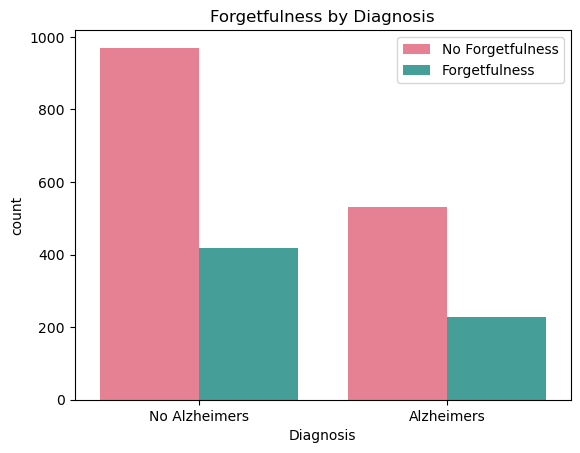

In [19]:
sns.countplot(data=alzheimers_df, x='Diagnosis', hue='Forgetfulness', palette = 'husl')
plt.legend(labels=['No Forgetfulness','Forgetfulness'])
plt.xticks(ticks=[0,1], labels=['No Alzheimers','Alzheimers'])
plt.title(f'Forgetfulness by Diagnosis')
plt.show()

### Diabetes
- Diabetes was not significant according to a Chi Squared test (p-value = 0.16)

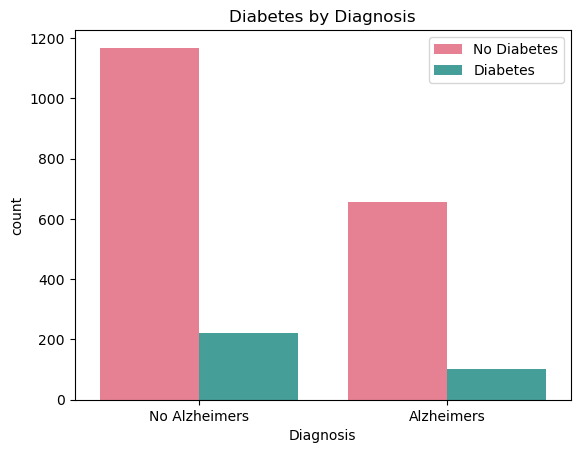

In [20]:
sns.countplot(data=alzheimers_df, x='Diagnosis', hue='Diabetes', palette = 'husl')
plt.legend(labels=['No Diabetes','Diabetes'])
plt.xticks(ticks=[0,1], labels=['No Alzheimers','Alzheimers'])
plt.title(f'Diabetes by Diagnosis')
plt.show()

### CardiovascularDisease
- Cardiovascular disease was not significant according to a Chi Squared test(p-value = 0.16)

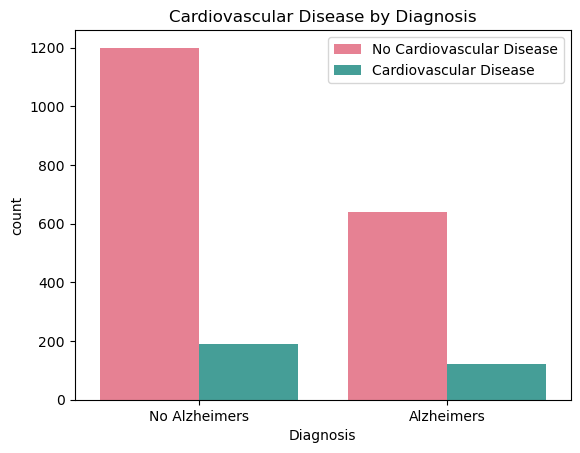

In [21]:
sns.countplot(data=alzheimers_df, x='Diagnosis', hue='CardiovascularDisease', palette = 'husl')
plt.legend(labels=['No Cardiovascular Disease','Cardiovascular Disease'])
plt.xticks(ticks=[0,1], labels=['No Alzheimers','Alzheimers'])
plt.title(f'Cardiovascular Disease by Diagnosis')
plt.show()

### Training

In [22]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(
        conf_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )
    class_report = classification_report(y_test, y_pred)
    
    print(f"{model_name} Accuracy:", accuracy)
    print(f"{model_name} AUC:", auc)
    print(f"{model_name} Confusion Matrix:\n", conf_matrix_df)
    print(f"{model_name} Classification Report:\n", class_report)
    
    return model, y_pred, y_prob


In [23]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=500, random_state=5)

# Train and evaluate the Random Forest model
rf_model, y_pred_rf, y_prob_rf  = train_and_evaluate(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")



Random Forest Accuracy: 0.9465116279069767
Random Forest AUC: 0.9589161682423307
Random Forest Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0          275            9
Actual 1           14          132
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       284
           1       0.94      0.90      0.92       146

    accuracy                           0.95       430
   macro avg       0.94      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430



C:\Users\jacob\AppData\Local\Temp\ipykernel_10420\1558297641.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y=rf_importance_df.index, data=rf_importance_df, palette='RdYlBu')


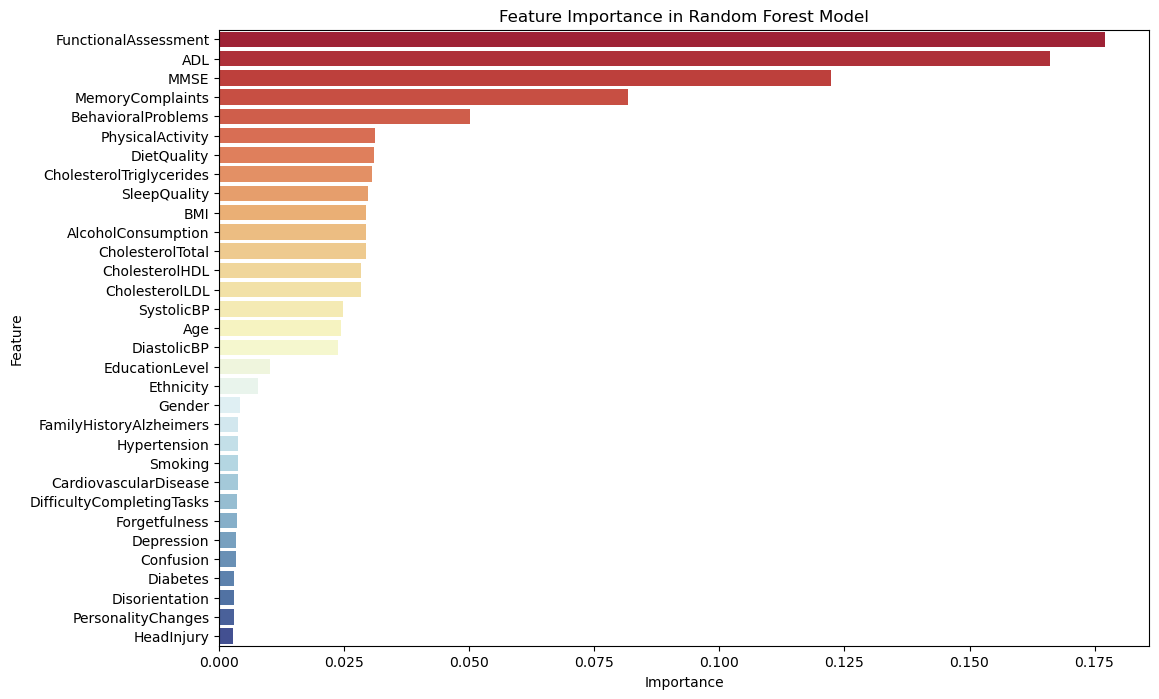

In [24]:
# Feature importance for Random Forest
rf_feature_importance = rf_model.feature_importances_
rf_importance_df = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
#rf_importance_df = pd.DataFrame(list(zip(alzheimers_df, rf_feature_importance)), columns=["Feature", "Importance"])
rf_importance_df = rf_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance for Random Forest using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y=rf_importance_df.index, data=rf_importance_df, palette='RdYlBu')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [25]:
# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=5)
dt_model, y_pred_dt, y_prob_dt = train_and_evaluate(
    dt_model, X_train_scaled, y_train, X_test_scaled, y_test, "Decision Tree"
)

Decision Tree Accuracy: 0.8883720930232558
Decision Tree AUC: 0.8888674512830408
Decision Tree Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0          252           32
Actual 1           16          130
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       284
           1       0.80      0.89      0.84       146

    accuracy                           0.89       430
   macro avg       0.87      0.89      0.88       430
weighted avg       0.89      0.89      0.89       430



C:\Users\jacob\AppData\Local\Temp\ipykernel_10420\2958492908.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=dt_importance_df, palette='PiYG')


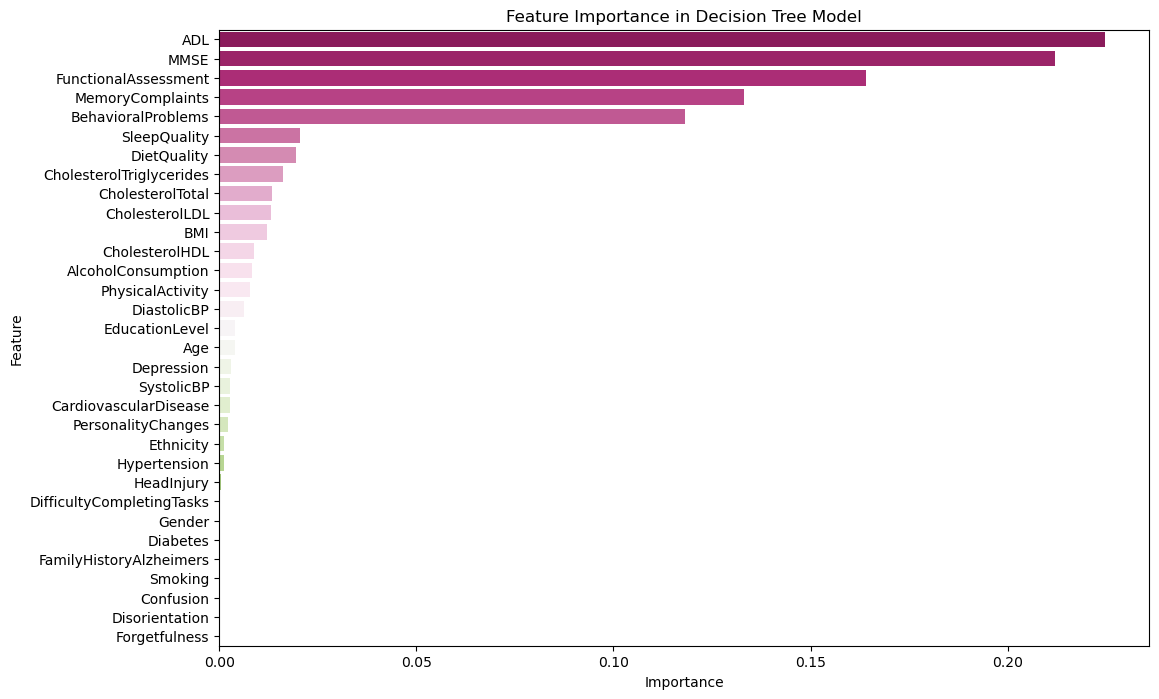

In [26]:
# Feature importance for Decision Tree
dt_feature_importance = dt_model.feature_importances_
dt_importance_df = pd.DataFrame(list(zip(alzheimers_df, dt_feature_importance)), columns=["Feature", "Importance"])
dt_importance_df = dt_importance_df.sort_values(by="Importance", ascending=False)

# Plot the feature importance for Decision Tree using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=dt_importance_df, palette='PiYG')
plt.title('Feature Importance in Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [27]:
# Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=5, max_depth=6)
gb_model, y_pred_gb, y_prob_gb = train_and_evaluate(
    gb_model, X_train_scaled, y_train, X_test_scaled, y_test, "Gradient Boosting"
)

Gradient Boosting Accuracy: 0.9511627906976744
Gradient Boosting AUC: 0.9557447424271657
Gradient Boosting Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0          272           12
Actual 1            9          137
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       284
           1       0.92      0.94      0.93       146

    accuracy                           0.95       430
   macro avg       0.94      0.95      0.95       430
weighted avg       0.95      0.95      0.95       430



In [28]:
# CatBoost model
cb_model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_state=5)
cb_model, y_pred_cb, y_prob_cb = train_and_evaluate(
    cb_model, X_train_scaled, y_train, X_test_scaled, y_test, "CatBoost"
)


CatBoost Accuracy: 0.9558139534883721
CatBoost AUC: 0.9546353463245224
CatBoost Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0          275            9
Actual 1           10          136
CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       284
           1       0.94      0.93      0.93       146

    accuracy                           0.96       430
   macro avg       0.95      0.95      0.95       430
weighted avg       0.96      0.96      0.96       430



In [29]:
# XGBoost model
xb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, verbosity=0, random_state=5, use_label_encoder=False, eval_metric='logloss')
xb_model, y_pred_xb, y_prob_xb = train_and_evaluate(
    xb_model, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost"
)

XGBoost Accuracy: 0.9511627906976744
XGBoost AUC: 0.9603511479837931
XGBoost Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0          274           10
Actual 1           11          135
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       284
           1       0.93      0.92      0.93       146

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.95       430
weighted avg       0.95      0.95      0.95       430



### ROC (Receiver Operating Characteristic) Curve and AUC (Area Under the Curve)
The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier as its discrimination threshold is varied. The Area Under the Curve (AUC) measures the entire two-dimensional area underneath the entire ROC curve.

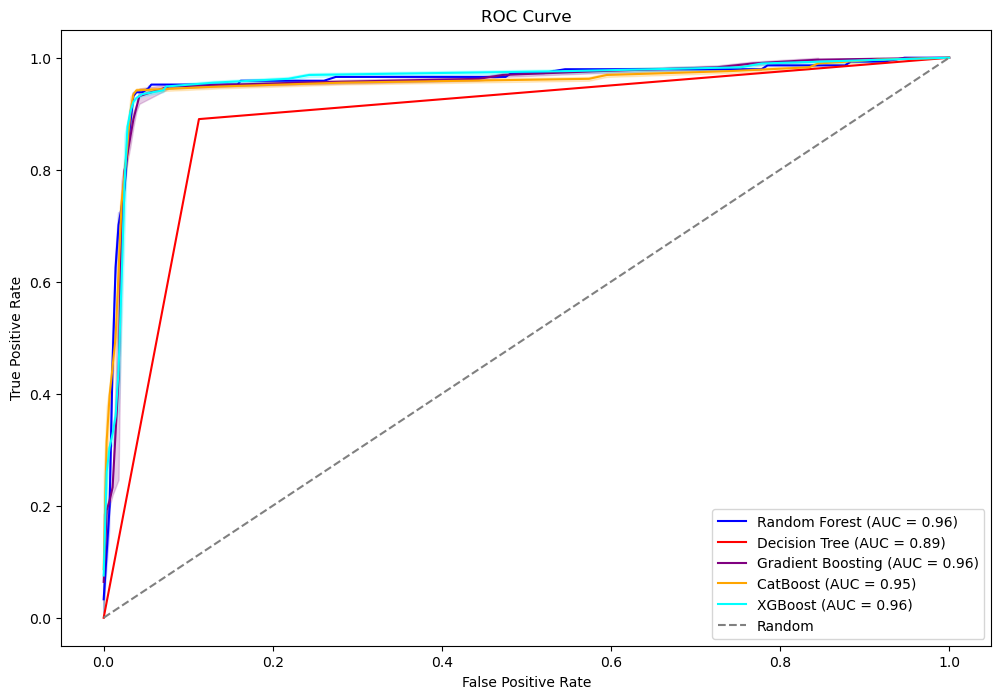

In [30]:
# Compute ROC curve for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_prob_cb)
fpr_xb, tpr_xb, _ = roc_curve(y_test, y_prob_xb)

# Plot ROC curves for all models
plt.figure(figsize=(12, 8))
sns.lineplot(x=fpr_rf, y=tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})', color='blue')
sns.lineplot(x=fpr_dt, y=tpr_dt, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_prob_dt):.2f})', color='red')
sns.lineplot(x=fpr_gb, y=tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_score(y_test, y_prob_gb):.2f})', color='purple')
sns.lineplot(x=fpr_cb, y=tpr_cb, label=f'CatBoost (AUC = {roc_auc_score(y_test, y_prob_cb):.2f})', color='orange')
sns.lineplot(x=fpr_xb, y=tpr_xb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob_xb):.2f})', color='cyan')
sns.lineplot(x=[0, 1], y=[0, 1], label='Random', color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

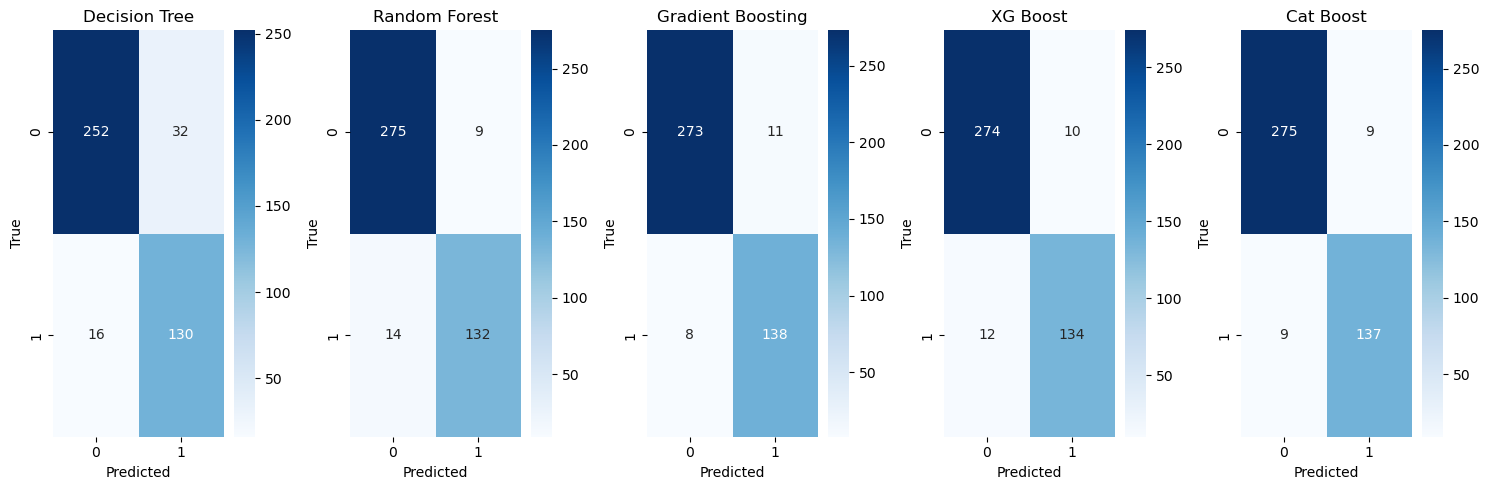

Accuracy Scores:
                Model  Accuracy
0      Decision Tree  0.888372
1      Random Forest  0.946512
2  Gradient Boosting  0.955814
3           XG Boost  0.948837
4          Cat Boost  0.958140

Classification Report for Decision Tree:

              precision    recall  f1-score     support
0              0.940299  0.887324  0.913043  284.000000
1              0.802469  0.890411  0.844156  146.000000
accuracy       0.888372  0.888372  0.888372    0.888372
macro avg      0.871384  0.888867  0.878600  430.000000
weighted avg   0.893501  0.888372  0.889654  430.000000

Classification Report for Random Forest:

              precision    recall  f1-score     support
0              0.951557  0.968310  0.959860  284.000000
1              0.936170  0.904110  0.919861  146.000000
accuracy       0.946512  0.946512  0.946512    0.946512
macro avg      0.943864  0.936210  0.939861  430.000000
weighted avg   0.946333  0.946512  0.946279  430.000000

Classification Report for Gradient Bo

In [31]:
#ALL FEATURES
# Initialize models
models = {
    "Decision Tree": tree.DecisionTreeClassifier(random_state=5),
    "Random Forest": RandomForestClassifier(n_estimators = 500, random_state=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=5),
    "XG Boost": XGBClassifier(random_state=5),
    "Cat Boost": CatBoostClassifier(random_state=5, verbose=0)
}

# Create dictionaries to store metrics
confusion_matrices = {}
accuracy_scores = {}
classification_reports = {}

for name, model in models.items():
    # Fit model
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Compute metrics
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    accuracy_scores[name] = accuracy_score(y_test, y_pred)
    classification_reports[name] = classification_report(y_test, y_pred, output_dict=True)

# Plot confusion matrices
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))
for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

# Display accuracy scores and classification reports
accuracy_df = pd.DataFrame(accuracy_scores.items(), columns=['Model', 'Accuracy'])
print("Accuracy Scores:\n", accuracy_df)

for model, report in classification_reports.items():
    print(f"\nClassification Report for {model}:\n")
    print(pd.DataFrame(report).transpose())

## Re-split and Scale the Data for Top 10 Feature Importances

In [35]:
#get the top 10 in the feature importances as a list
top_10 = rf_importance_df.index.to_list()[:10]
y = alzheimers_df['Diagnosis']

#top 10 features df
Xtop10 = alzheimers_df[top_10]

#re-do train-test split with top 10 features df
X_train_top10, X_test_top10, y_train, y_test = train_test_split(Xtop10, y, test_size=0.2, random_state = 5)
print(X_train_top10.shape)

#Scale the features
scaler = StandardScaler()
X_scaler_top10 = scaler.fit(X_train_top10)
X_train_scaled_top10 = X_scaler_top10.transform(X_train_top10)
X_test_scaled_top10 = X_scaler_top10.transform(X_test_top10)


(1719, 10)


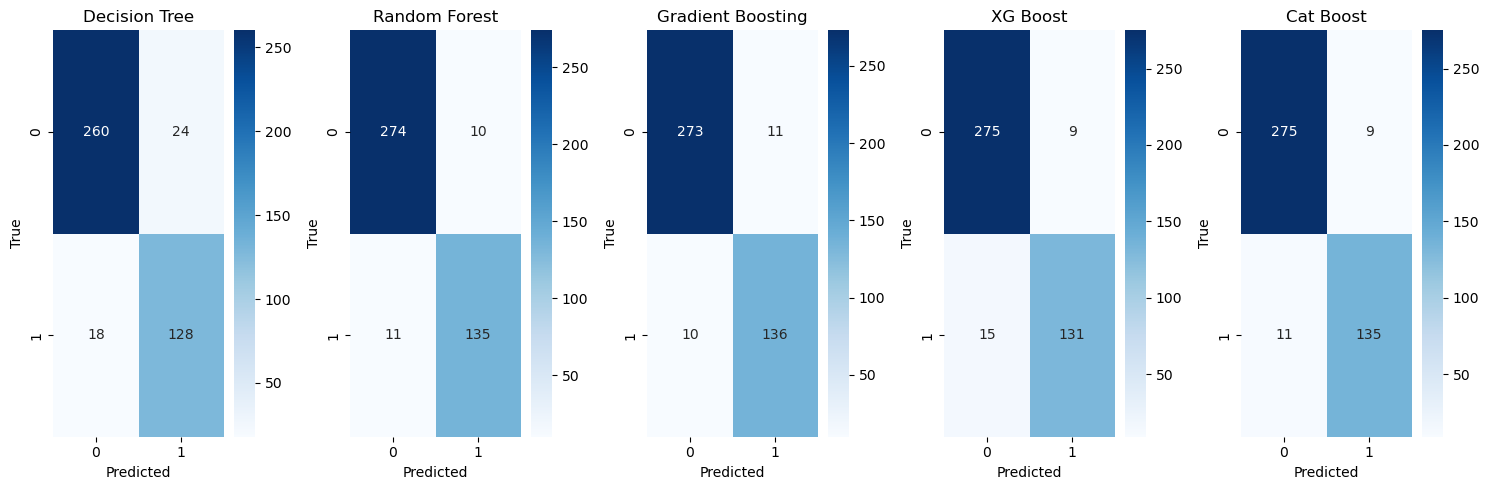

Accuracy Scores:
                Model  Accuracy
0      Decision Tree  0.902326
1      Random Forest  0.951163
2  Gradient Boosting  0.951163
3           XG Boost  0.944186
4          Cat Boost  0.953488

Classification Report for Decision Tree:

              precision    recall  f1-score     support
0              0.935252  0.915493  0.925267  284.000000
1              0.842105  0.876712  0.859060  146.000000
accuracy       0.902326  0.902326  0.902326    0.902326
macro avg      0.888679  0.896103  0.892164  430.000000
weighted avg   0.903625  0.902326  0.902787  430.000000

Classification Report for Random Forest:

              precision    recall  f1-score     support
0              0.961404  0.964789  0.963093  284.000000
1              0.931034  0.924658  0.927835  146.000000
accuracy       0.951163  0.951163  0.951163    0.951163
macro avg      0.946219  0.944723  0.945464  430.000000
weighted avg   0.951092  0.951163  0.951122  430.000000

Classification Report for Gradient Bo

In [36]:
# TOP 10 FEATURES
# Initialize models
models = {
    "Decision Tree": tree.DecisionTreeClassifier(random_state=5),
    "Random Forest": RandomForestClassifier(n_estimators = 500, random_state=5),
    "Gradient Boosting": GradientBoostingClassifier(random_state=5),
    "XG Boost": XGBClassifier(random_state=5),
    "Cat Boost": CatBoostClassifier(random_state=5, verbose=0)
}

# Create dictionaries to store metrics
confusion_matrices = {}
accuracy_scores = {}
classification_reports = {}

for name, model in models.items():
    # Fit model
    model.fit(X_train_scaled_top10, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled_top10)
    
    # Compute metrics
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    accuracy_scores[name] = accuracy_score(y_test, y_pred)
    classification_reports[name] = classification_report(y_test, y_pred, output_dict=True)

# Plot confusion matrices
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))
for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

# Display accuracy scores and classification reports
accuracy_df = pd.DataFrame(accuracy_scores.items(), columns=['Model', 'Accuracy'])
print("Accuracy Scores:\n", accuracy_df)

for model, report in classification_reports.items():
    print(f"\nClassification Report for {model}:\n")
    print(pd.DataFrame(report).transpose())